"""
A model for the C-P-U evolution 310-285 Ma
Author: Shihan Li
Several steps:
1. Auto spin to steady state in the beginning
2. Inverse to fit pco2 and d13c 
3. For d13c, randomly assume the other end-member d13c for co2 source
4. Output the U isotope value, compare with proxy records

Initial steady state: 
1. t = 310Ma
2. pCO2 = 500e-6
3. o = 4.4e19 (after COPSE results)
4. d13c = 4.42 (after proxy records)
5. d235u = -0.14 (after proxy records)

Forcing：
1. Paleogeography effect on runoff/weatheirng (Royer et al., 2014)
2. Metamorphic and volcanic degassing, inversion of sea-level curve. (Mills et al., 2017) ｜ or GEOCARBSURF (but low resolution)
3. tectonic uplift from sediment accumulation rates (Royer et al. 2014)
4. Land plant evolution on weathering. Always 1. Lenton et al., 2016
5. Plant enhancement of weathering. Always 1. Lenton et al., 2012

"""

In [9]:
# load packages
import numpy as np
from scipy.integrate import solve_ivp  
import timeit
import pandas as pd
import matplotlib.pyplot as plt


import load_forcings as ffunc         # COPSE_reloaded forcings
import functions as fts               # functions for ODE

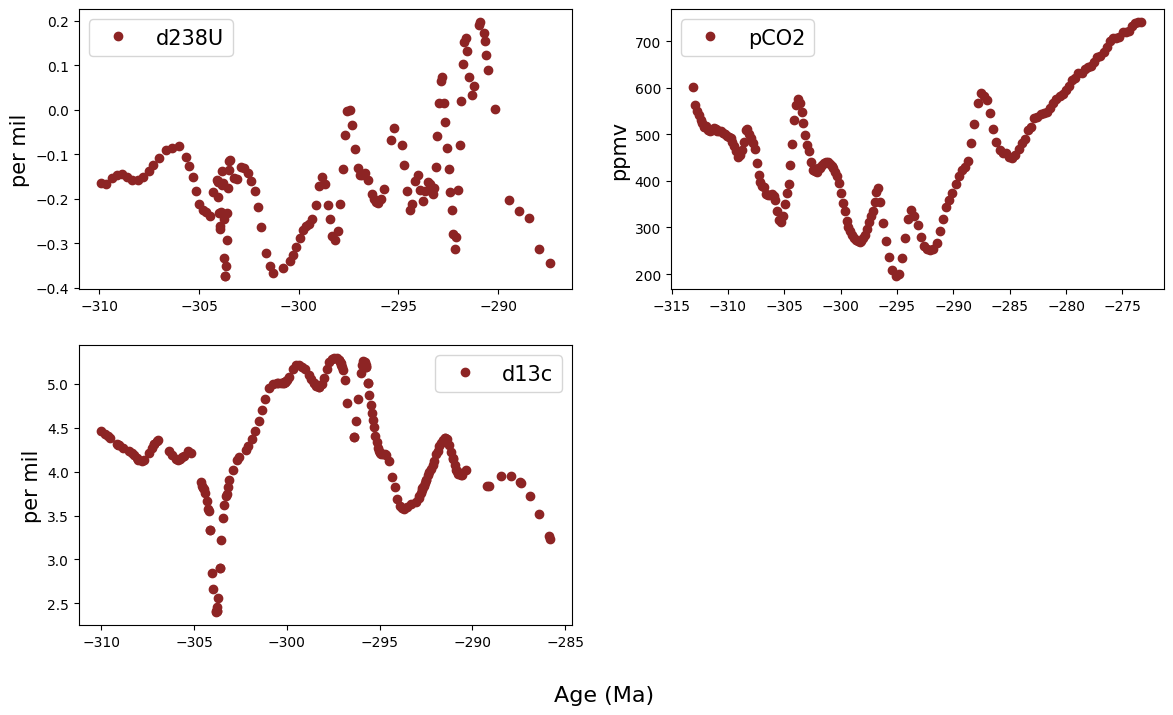

In [33]:
# load the proxy data
file_name = 'fit_data.xlsx'
df_u = pd.read_excel(file_name, sheet_name = 'U_AC_10%_LOESS')
df_d13c = pd.read_excel(file_name, sheet_name = 'C_AC_10%_LOESS')
df_pco2 = pd.read_excel(file_name, sheet_name = 'pCO2_LOESS')
fig, axs = plt.subplots(2,2, figsize = (14,8))

axs[0,0].plot(-df_u.age, df_u['mean'], marker = 'o', c='#8d2424', ls = '', label = 'd238U')
axs[1,0].plot(-df_d13c.age, df_d13c['mean'], marker = 'o',c='#8d2424', ls='', label = 'd13c')
axs[0,1].plot(-df_pco2['Age (Ma)'], df_pco2['LOESS CO2'], marker = 'o', c='#8d2424', ls='', label = 'pCO2')
axs[1,1].remove()

fig.supxlabel('Age (Ma)', fontsize=16, color="black")
axs[0,0].set_ylabel('per mil', fontsize = 15)
axs[1,0].set_ylabel('per mil', fontsize = 15)
axs[0,1].set_ylabel('ppmv', fontsize = 15)

axs[0,0].tick_params(axis="both", labelsize=10)
axs[0,1].tick_params(axis="both", labelsize=10)
axs[1,0].tick_params(axis="both", labelsize=10)

axs[0,0].legend(fontsize = 15)
axs[1,0].legend(fontsize = 15)
axs[0,1].legend(fontsize = 15)

In [42]:
# Some constants
# Allow some uncertainties for MC simulation later
k_CtoK = 273.15    # convert degrees C to Kelvin
k_c = 4.3280                 # new determines climate sensitivity to CO2
k_l = 7.4000                 # new determines temperature sensitivity to luminosity
k_planenhance = 0.15         # plant enhancement of weathering
f_oxw_a = 0.5                # oxidative weathering dependency on O2 concentration
k_logistic = 12              # new determines slope of logistic anoxia function, COPSE_reloaded, Clarkson et al. 2018
k_uptake = 0.5000            # new determines efficiency of nutrient uptake in anoxia function; COPSE_reloaded; Clarkson et al. 2018
# newp0 = 225.956              # new production (umol/kg)
newp0 = 117 * 2.2         
k_oxfrac = 0.9975            # updated initial oxic fraction
f_mocb_b = 2                 # marine organic carbon burial dependency on new production
k_oceanmass = 1.397e21       # ocean mass (kg)

In [43]:
# Modern Flux
# Carbon, processes considered here: volcanic degassing, weathering (organic, carbonate, silicate), burial (continental organic, marine organic, carbonate)
k_ccdeg = 8e12      # volcanic degassing
k_silw = 8e12       # silicate weathering
k_carbw = 8e12      # carbonate weathering
k_mccb = k_silw + k_carbw # carbonate burial

k_oxidw = 5e12      # oxidative weatheirng + degassing 
k_locb = 2.5e12     # continental organic C burial
k_mocb = 2.5e12     # marine organic C burial

pco2atm0 = 280e-6      # pco2 corresponding to a0 (atm)
a0 = 3.193e18       # atmosphere-ocean co2
o0 = 3.7e19         # atmosphere-ocean o2

# P
p0 = 3.1e15         # ocean (phosphate) phosphorus
# n0 = 4.35e16        # ocean (reactive) nitrogen
k_fepb = 1e10       # fe-p burial
k_capb = 2*k_fepb      # ca-p burial
k_mopb = k_fepb      # organic-P burial
k_phosw = 4*k_fepb      # phosphate weathering 
   

# U
u0 = 1.85e13         # modern U in the ocean

u_riv0 = 4.79e7       # river input
u_hydro0 = 5.7e6      # hydrothermal output
u_anox0 = 6.2e6       # anoxic sink
u_sed0 = 3.6e7         
    
# isotope fractionations
d238u_riv = -0.29
u_frac_anox = 0.5
u_frac_sed = 0.0156
u_frac_hydro = 0.2


In [115]:
u_riv0-u_hydro0-u_anox0-u_sed0

0.0

In [125]:
# initial values
t_i = -310e6
t_Ma_i = t_i/1e6

pco2_i = 500e-6                      # after proxy data
pco2pal_i = pco2_i/pco2atm0     
a_i = a0 * np.sqrt(pco2pal_i)
temp_i = k_CtoK + 15 + k_c * np.log(pco2pal_i) + k_l * t_i/570e6   # luminosity used imiplicitly
                                                                   # corrected 0 degrees by the sea surface temperature record
o_i = o0*1.1         # after COPSE result, equivalent to 25% O2atm, o2_pal 1.19

po2pal_i = o_i/o0    # relative o2 concentration 


# after proxy
delta_ocn_i = 4.42
delta_u_i = -0.14-0.27



In [126]:
# C cycle
# forcing parameter, degassing, uplift driving erosion, effects of vegetation and lithology on weatherability
PG_i = ffunc.fPG(t_Ma_i)                        # Paleogeography effect on runoff/weathering, (Royer et al., 2014)
DEGASS_i = ffunc.fhaq_D(t_Ma_i)                 # metamorphic and volcanic degassing, inversion of sea-level curve. (Mills et al., 2017) 
UPLIFT_i = ffunc.fUPLIFT(t_Ma_i)                # tectonic uplift from sediment accumulation rates
                                                # Royer et al. 2014
EVO_i = ffunc.fEVO(t_Ma_i)                      # Land plant evolution
W_i = ffunc.fW(t_Ma_i)                          # Land plant enhancement of weathering
# W_i = 0.875                                   # GEOCARBSURF

# degassing
ccdeg_i = k_ccdeg * DEGASS_i

# silicate weathering, assumed equal to degassing for a steady state
silw_i = ccdeg_i

# biomass
VEG_i = fts.land_biota(temp_i-k_CtoK, pco2_i, po2pal_i, EVO_i) 

# weathering rates, activation energy as 62 kJ/mol
f_T_silw_i = np.exp(0.09 * (temp_i-288.15))
f_T_ap_i = np.exp(0.0507 * (temp_i - 288.15))  # 35 kJ/mol

# runoff temperature dependence
f_T_runoff_i = ((1 + 0.038 * (temp_i - 288.15))**0.65)

f_co2_abiotic_i = pco2pal_i ** 0.5 

f_co2_biotic = (2*pco2pal_i / (1+pco2pal_i))**0.4

VWmin_i = min(VEG_i * W_i, 1)


# carbonate weathering, depend on runoff, vegetation, and co2, after COPSE reloaded
g_T_runoff_i = 1 + 0.087 * (temp_i - 288.15)             # runoff on carbonate
f_carb_i = g_T_runoff_i * ((1-VWmin_i) * k_planenhance * f_co2_abiotic_i + VEG_i * W_i)
carbw_i = k_carbw * PG_i * f_carb_i

# oxidw
oxw_fac_i = po2pal_i ** f_oxw_a
oxidw_i = k_oxidw * oxw_fac_i *DEGASS_i

# burial
mccb_i = silw_i + carbw_i                # dALK = 0
# locb_i = k_locb * VEG_i                  # continental burial
locb_i = oxidw_i * 0.5                   # continental and ocean burial in 1:1
mocb_i = oxidw_i * 0.5                   # dTC = 0

ap_i = oxidw_i  - locb_i - mocb_i + ccdeg_i - silw_i

In [127]:
# P cycle, set weathering = burial
p_i = p0 * np.sqrt(mocb_i/k_mocb)
# p_i = p0 * (mocb_i/k_mocb)
Pconc_i = (p_i/p0) * 2.2

# marine new production
newp_i = 117 * Pconc_i
# anoxic
ANOX_i =  1/(1+np.exp(-k_logistic * (k_uptake * (newp_i/newp0)-po2pal_i)))



# phosw_i = k_phosw * silw_i/k_silw 
mopb_i = mocb_i * ((ANOX_i/1000)+((1-ANOX_i)/250))  # ocean burial

fepb_i = (k_fepb/k_oxfrac)*(1-ANOX_i)*(p_i/p0)      # fe-p 

capb_i = k_capb * ((newp_i/newp0)**f_mocb_b)        # ca3po4 burial


# phosphorous balance
phosw_i = mopb_i+fepb_i+capb_i

In [128]:
# C isotope, adjust the org weatheirng d13c
phi_i = 0.01614 * (a_i / a0)   # fraction of C in atmosphere:ocean    


d_locb_i, D_P_i, d_mocb_i, D_B_i, d_mccb_i, d_ocean_i, d_atmos_i = fts.Cisotopefrac(temp_i, pco2pal_i, po2pal_i, phi_i)

delta_a_i = delta_ocn_i - d_ocean_i
delta_mccb_i = delta_a_i + d_mccb_i

d_mocb_i = -30
d_locb_i = -30

delta_g = -26
delta_c = 4.5
delta_vol = 0
# delta_mccb_i = 0
delta_g = (locb_i * ( delta_a_i+d_locb_i) + mocb_i * (delta_a_i+d_mocb_i) - ccdeg_i * delta_vol - carbw_i * delta_c + mccb_i * delta_mccb_i)/oxidw_i  
print(delta_g)
moldelta_a_i = delta_a_i * a_i


-18.246631700807946


In [147]:
# U, adjust the other
u_i = 1.96e13 
u_riv_i = u_riv0 * silw_i/k_silw
u_hydro_i = u_hydro0 * DEGASS_i 
u_anox_i = u_anox0 * (ANOX_i/0.0025) *u_i/u0
u_other_i = u_riv_i-u_hydro_i-u_anox_i

# isotope
delta_u_riv = -0.29
d_u_hydro = 0.2
delta_u_hydro = delta_u_i + d_u_hydro
d_u_anox = 0.6
delta_u_anox = delta_u_i + d_u_anox

delta_u_other = (u_riv_i * delta_u_riv - delta_u_hydro * u_hydro_i - delta_u_anox*u_anox_i)/u_other_i

In [151]:
### ODE setup ####

In [154]:
ccdeg_i

9980609339569.201